# **Classifying Breast Cancer**

## Project Overview

**Objective:** Build a machine learning classifier to predict breast cancer malignancy from clinical measurements.

**Goal:** Achieve high recall (95%+) to minimize missed cancer diagnoses while maintaining acceptable precision.

**Approach:** Compare 6 classification algorithms using stratified cross-validation, then evaluate the best model on a held-out test set.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset (569 samples, 3 features)

### **Setup and Imports**

In [12]:
#library imports
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
RANDOM_STATE = 42

In [13]:
# data loading (portable: works in Colab or locally)
DATA_PATH = Path("breast-cancer.csv")

if DATA_PATH.exists():
    df_data = pd.read_csv(DATA_PATH)
else:
    # fallback: scikit-learn Breast Cancer Wisconsin (Diagnostic) dataset
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer(as_frame=True)
    df_data = data.frame.copy()

    # convert target to the common 'diagnosis' format used in many CSV versions:
    # 0 = malignant, 1 = benign  (scikit-learn)
    df_data["diagnosis"] = df_data["target"].map({0: "M", 1: "B"})

    # rename key features to match the notebook's expected column names
    df_data = df_data.rename(columns={
        "worst area": "area_worst",
        "worst smoothness": "smoothness_worst",
        "mean texture": "texture_mean",
    })


**Data source note.** This notebook supports a local CSV named `breast-cancer.csv`. If the file is not found, it falls back to the Breast Cancer Wisconsin (Diagnostic) dataset available in `scikit-learn` (for reproducibility).

In [14]:
df_data.head()

,mean radius,texture_mean,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,area_worst,smoothness_worst,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,M


### **Data Quality Report: types, missing, duplicates**






In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [16]:
df_data.duplicated().sum()

np.int64(0)

### **EDA**







In [17]:
#data trim, per study "best predictive accuracy obtained using one separating plane in the 3-D space of Worst Area, Worst Smoothness and Mean Texture."
df = df_data[['diagnosis', 'area_worst', 'smoothness_worst', 'texture_mean']].copy()
df.head()

,diagnosis,area_worst,smoothness_worst,texture_mean
0,M,2019.0,0.1622,10.38
1,M,1956.0,0.1238,17.77
2,M,1709.0,0.1444,21.25
3,M,567.7,0.2098,20.38
4,M,1575.0,0.1374,14.34


In [18]:
# converting diagnosis to binary
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
df.head()

,diagnosis,area_worst,smoothness_worst,texture_mean
0,1,2019.0,0.1622,10.38
1,1,1956.0,0.1238,17.77
2,1,1709.0,0.1444,21.25
3,1,567.7,0.2098,20.38
4,1,1575.0,0.1374,14.34


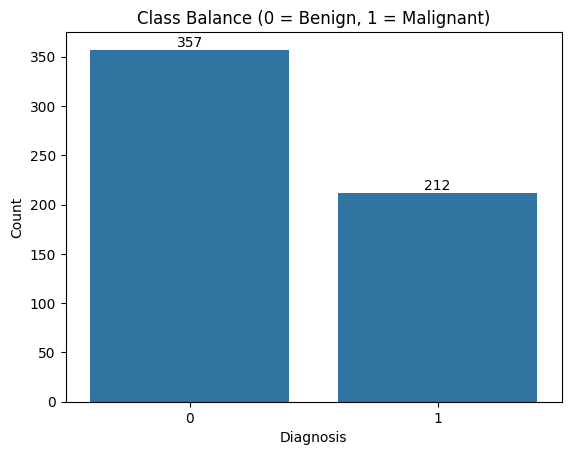

In [19]:
# bar chart showing class balance (0 = benign, 1 = malignant)
ax = sns.countplot(x='diagnosis', data=df)
ax.set_title("Class Balance (0 = Benign, 1 = Malignant)")
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Count")

for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [20]:
# percentage of binary class
labels = {0: "Benign (0)", 1: "Malignant (1)"}
class_pct = (df["diagnosis"].value_counts(normalize=True) * 100).round(2)
class_pct.index = class_pct.index.map(labels)
print("Class percentage (%):\n", class_pct)

Class percentage (%):
 diagnosis
Benign (0)       62.74
Malignant (1)    37.26
Name: proportion, dtype: float64


In [21]:
target = "diagnosis"
features = [c for c in df.columns if c != target]

In [22]:
# get summary stats on continuous
df[features].describe()

,area_worst,smoothness_worst,texture_mean
count,569.000000,569.000000,569.000000
mean,880.583128,0.132369,19.289649
std,569.356993,0.022832,4.301036
min,185.200000,0.071170,9.710000
25%,515.300000,0.116600,16.170000
50%,686.500000,0.131300,18.840000
75%,1084.000000,0.146000,21.800000
max,4254.000000,0.222600,39.280000


### **Univariate Analysis**

In [23]:
quality = pd.DataFrame({
    "missing": df[features].isna().sum(),
    "unique": df[features].nunique(),
    "min": df[features].min(),
    "mean": df[features].mean(),
    "max": df[features].max()
}).reset_index().rename(columns={"index": "feature"})

quality

,feature,missing,unique,min,mean,max
0,area_worst,0,544,185.20000,880.583128,4254.0000
1,smoothness_worst,0,411,0.07117,0.132369,0.2226
2,texture_mean,0,479,9.71000,19.289649,39.2800


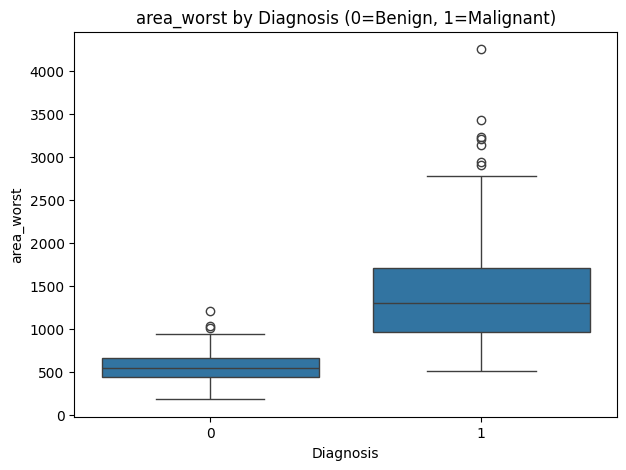

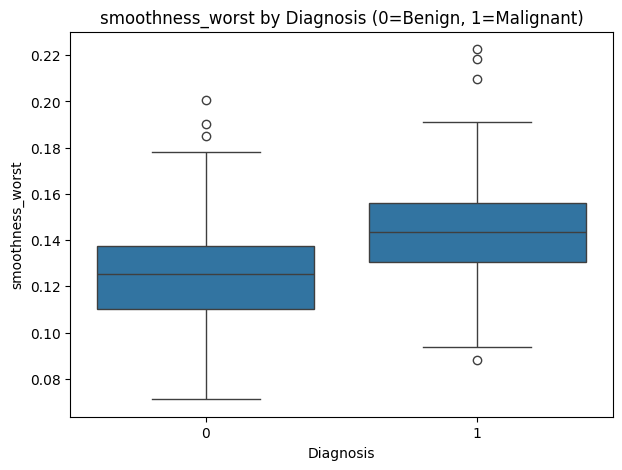

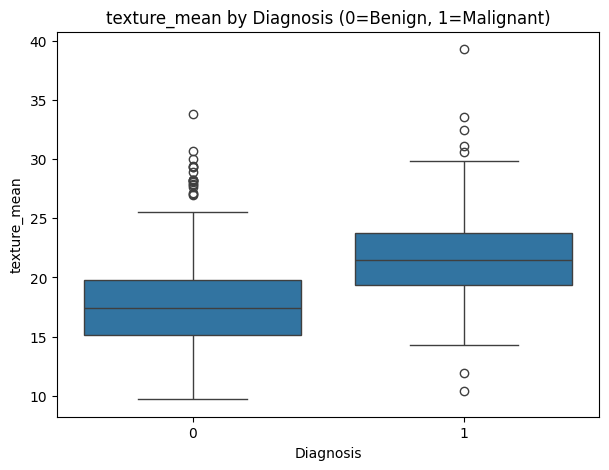

In [24]:
# boxplots for diagnosis
for col in features:
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df, x=target, y=col)
    plt.title(f"{col} by Diagnosis (0=Benign, 1=Malignant)")
    plt.xlabel("Diagnosis")
    plt.ylabel(col)
    plt.show()

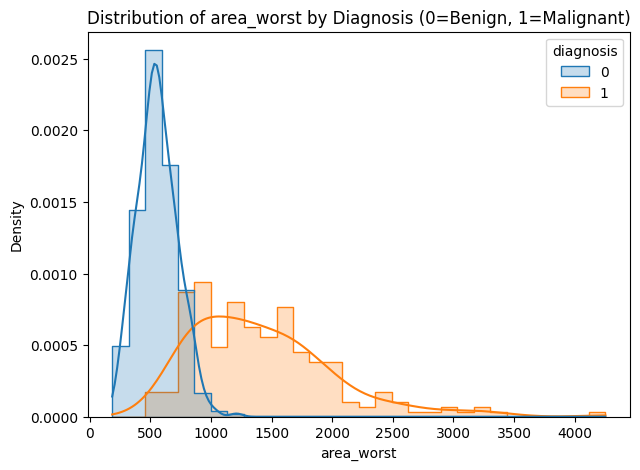

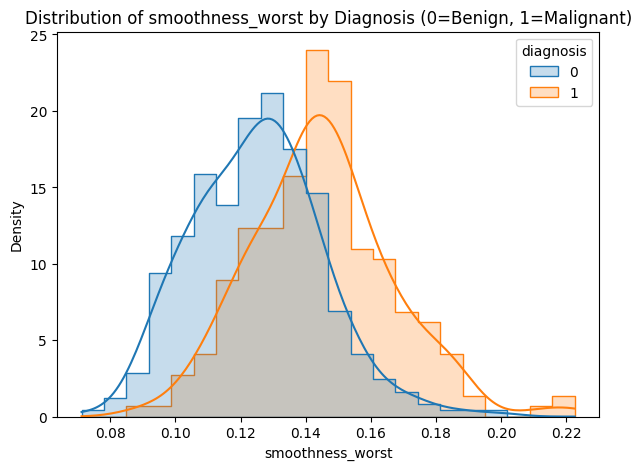

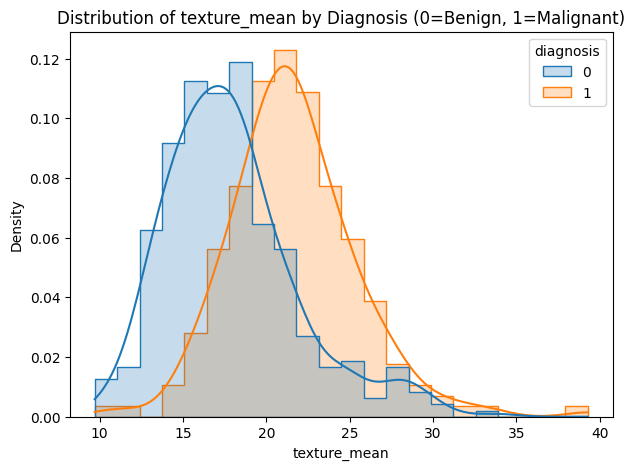

In [25]:
# histograms with hue
for col in features:
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=df, x=col, hue=target, kde=True,
        element="step", stat="density", common_norm=False
    )
    plt.title(f"Distribution of {col} by Diagnosis (0=Benign, 1=Malignant)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

### **Multivariate analysis (relationships between features)**

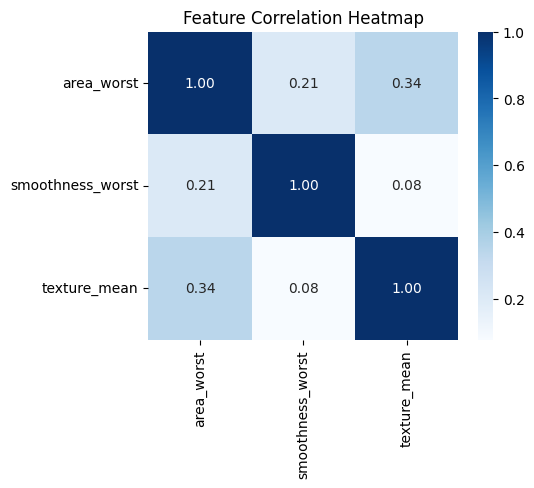

In [26]:
# correlation heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()

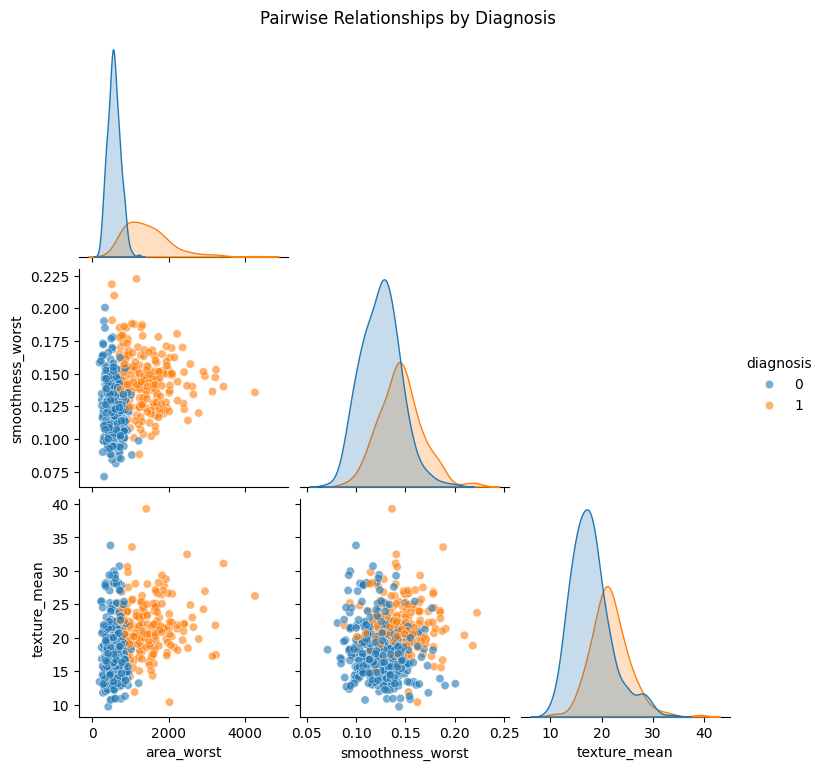

In [27]:
# pairplot shows separation patterns
sns.pairplot(df, vars=features, hue=target, corner=True, plot_kws={"alpha": 0.6})
plt.suptitle("Pairwise Relationships by Diagnosis", y=1.02)
plt.show()

### **Feature Engineering**

In [28]:
# features (x) and target (y)
X = df[['area_worst', 'smoothness_worst', 'texture_mean']].copy()
y = df['diagnosis'].astype(int).copy()

In [29]:
# train/test split (80/20) with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 455 samples
Test set size: 114 samples

Training set class distribution:
diagnosis
0    285
1    170
Name: count, dtype: int64

Test set class distribution:
diagnosis
0    72
1    42
Name: count, dtype: int64


### **Stratified K-Fold Partitioning**

Stratified CV on training using a Pipeline

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

scores = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
)

pd.DataFrame(scores).drop(columns=["fit_time", "score_time"]).agg(["mean", "std"]).T

,mean,std
test_accuracy,0.970129,0.013288
test_precision,0.968475,0.030059
test_recall,0.953045,0.059404
test_f1,0.959092,0.019878
test_roc_auc,0.992478,0.007733


In [31]:
# partitioning (counts per fold)
fold_counts = []
for _, test_idx in cv.split(X, y):
    fold_counts.append(np.bincount(y.iloc[test_idx], minlength=2))

fold_df = pd.DataFrame(fold_counts, columns=["Benign (0)", "Malignant (1)"])
fold_df

,Benign (0),Malignant (1)
0,71,43
1,71,43
2,72,42
3,72,42
4,71,42


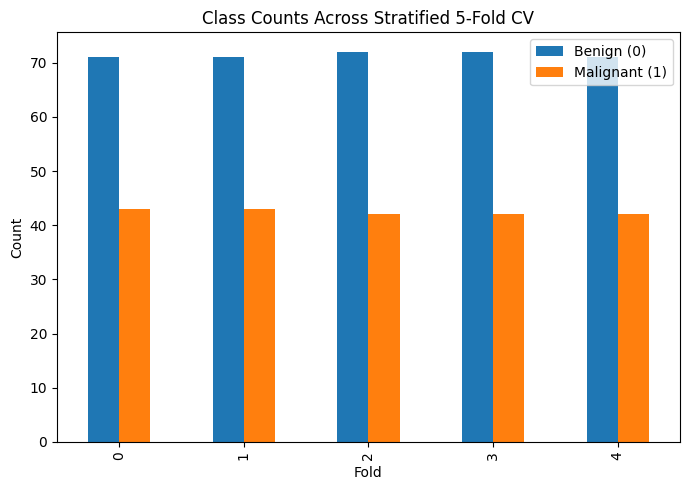

In [32]:
# fold class distribution bar chart
fold_counts = []
for fold, (_, test_idx) in enumerate(cv.split(X, y)):
    counts = np.bincount(y.iloc[test_idx], minlength=2)
    fold_counts.append([fold, counts[0], counts[1]])

fold_df = pd.DataFrame(fold_counts, columns=["Fold", "Benign (0)", "Malignant (1)"])

ax = fold_df.set_index("Fold").plot(kind="bar", figsize=(7, 5))
ax.set_title("Class Counts Across Stratified 5-Fold CV")
ax.set_xlabel("Fold")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

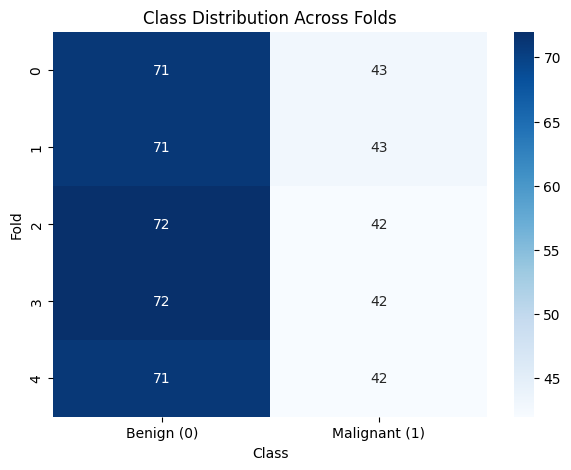

In [33]:
# heatmap showing the folds
plt.figure(figsize=(7, 5))
sns.heatmap(
    fold_df[["Benign (0)", "Malignant (1)"]],
    annot=True, fmt="d", cmap="Blues"
)
plt.title("Class Distribution Across Folds")
plt.xlabel("Class")
plt.ylabel("Fold")
plt.show()

### **Models**

Logistic Regression, Neural Net, Random Forest, CART, 

In [34]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "Neural Net (MLP)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPClassifier(hidden_layer_sizes=(15, 7), max_iter=1500, random_state=RANDOM_STATE))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, class_weight="balanced"
    ),
    "CART (Gini Tree)": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Entropy Tree (C5.0 proxy)": DecisionTreeClassifier(criterion="entropy", random_state=RANDOM_STATE),
    "Naive Bayes (Gaussian)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", GaussianNB())
    ])
}

def get_scores_for_auc(model, X_test):
    """
    Returns continuous scores for ROC/AUC:
    - predict_proba (positive class) if available
    - decision_function if available
    - None otherwise
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_test)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X_test)
    return None

def evaluate_models_cv(models, X, y, cv):
    rows = []
    roc_data = {}  # store per-model fold ROC curves for mean ROC plot

    for name, base_model in models.items():
        accs, pres, recs, f1s, aucs_ = [], [], [], [], []
        tprs = []
        mean_fpr = np.linspace(0, 1, 200)

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = clone(base_model)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            pres.append(precision_score(y_test, y_pred, zero_division=0))
            recs.append(recall_score(y_test, y_pred, zero_division=0))
            f1s.append(f1_score(y_test, y_pred, zero_division=0))

            scores = get_scores_for_auc(model, X_test)
            if scores is not None:
                fold_auc = roc_auc_score(y_test, scores)
                aucs_.append(fold_auc)

                fpr, tpr, _ = roc_curve(y_test, scores)
                tprs.append(np.interp(mean_fpr, fpr, tpr))
            # if no probability/score, we skip AUC for this fold

        # summaries
        row = {
            "Model": name,
            "Accuracy (mean)": np.mean(accs),
            "Accuracy (std)": np.std(accs, ddof=1),
            "Precision (mean)": np.mean(pres),
            "Precision (std)": np.std(pres, ddof=1),
            "Recall (mean)": np.mean(recs),
            "Recall (std)": np.std(recs, ddof=1),
            "F1 (mean)": np.mean(f1s),
            "F1 (std)": np.std(f1s, ddof=1),
        }

        if len(aucs_) > 0:
            row["ROC–AUC (mean)"] = np.mean(aucs_)
            row["ROC–AUC (std)"] = np.std(aucs_, ddof=1)
            roc_data[name] = {"mean_fpr": mean_fpr, "tprs": tprs}
        else:
            row["ROC–AUC (mean)"] = np.nan
            row["ROC–AUC (std)"] = np.nan

        rows.append(row)

    results = pd.DataFrame(rows)
    # sort by ROC–AUC when available, otherwise by F1
    results = results.sort_values(
        by=["ROC–AUC (mean)", "F1 (mean)"], ascending=False, na_position="last"
    ).reset_index(drop=True)

    return results, roc_data

results, roc_data = evaluate_models_cv(models, X_train, y_train, cv)
results

,Model,Accuracy (mean),Accuracy (std),Precision (mean),Precision (std),Recall (mean),Recall (std),F1 (mean),F1 (std),ROC–AUC (mean),ROC–AUC (std)
0,Logistic Regression,0.969231,0.009194,0.969864,0.000766,0.947059,0.024608,0.958204,0.013022,0.989577,0.007022
1,Neural Net (MLP),0.969231,0.009194,0.975746,0.013574,0.941176,0.020797,0.958025,0.012815,0.987926,0.008957
2,Random Forest,0.956044,0.017375,0.969056,0.020873,0.911765,0.041595,0.939085,0.025181,0.986429,0.009154
3,Naive Bayes (Gaussian),0.953846,0.023824,0.963211,0.033647,0.911765,0.046504,0.936286,0.033388,0.981940,0.009085
4,Entropy Tree (C5.0 proxy),0.942857,0.021138,0.925878,0.047703,0.923529,0.039460,0.923699,0.027652,0.938958,0.021508
5,CART (Gini Tree),0.945055,0.020559,0.940345,0.026931,0.911765,0.058824,0.924739,0.030587,0.938338,0.027359


### **Mean ROC curves for all models**

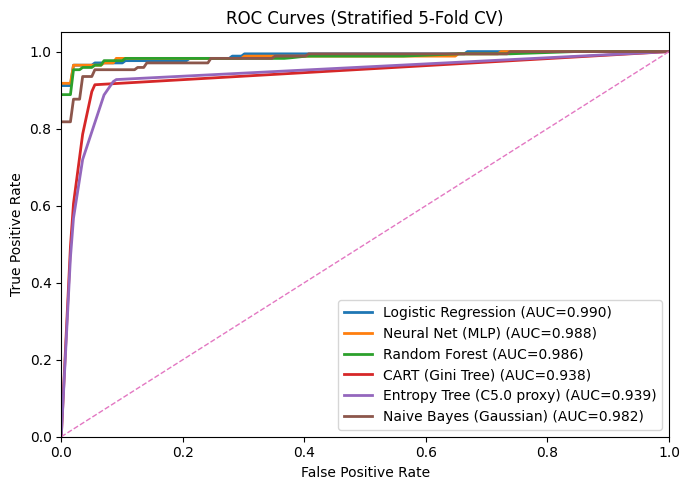

In [35]:
plt.figure(figsize=(7, 5))

for name, data in roc_data.items():
    mean_fpr = data["mean_fpr"]
    tprs = data["tprs"]

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{name} (AUC={mean_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Stratified 5-Fold CV)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## **Final holdout test evaluation**

Cross-validation estimates performance, but a final holdout test set provides a single unbiased evaluation after model selection.

### **Test Set Evaluation - Best Model**

Evaluation for the best-performing model (Logistic Regression) on the held-out test set.

In [36]:
# retrain best model on full training set
best_model = models["Logistic Regression"]
best_model.fit(X_train, y_train)

# predict on test set
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# calculate test metrics
test_results = {
    'Accuracy': accuracy_score(y_test, y_pred_test),
    'Precision': precision_score(y_test, y_pred_test),
    'Recall': recall_score(y_test, y_pred_test),
    'F1': f1_score(y_test, y_pred_test),
    'ROC-AUC': roc_auc_score(y_test, y_proba_test)
}

print("Test Set Performance - Logistic Regression")
print("="*50)
for metric, value in test_results.items():
    print(f"{metric:15s}: {value:.4f}")

Test Set Performance - Logistic Regression
Accuracy       : 0.9561
Precision      : 0.9302
Recall         : 0.9524
F1             : 0.9412
ROC-AUC        : 0.9960


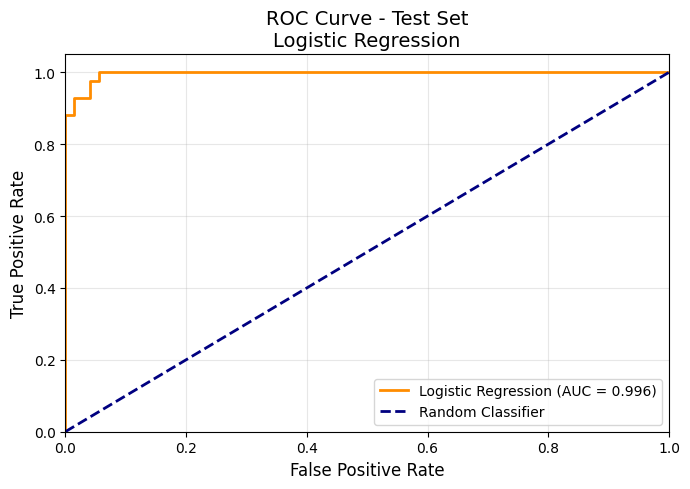

Test Set ROC-AUC: 0.9960


In [37]:
# ROC curve on test set
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set\nLogistic Regression', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Test Set ROC-AUC: {roc_auc:.4f}")

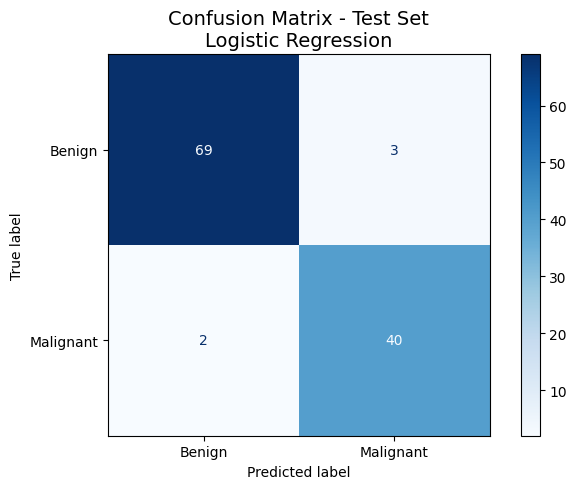


Confusion Matrix Breakdown:
  True Negatives (Correctly identified benign): 69
  False Positives (Benign predicted as malignant): 3
  False Negatives (Malignant predicted as benign): 2
  True Positives (Correctly identified malignant): 40

Clinical Interpretation:
  - Correctly identified 40/42 cancer cases (95.2%)
  - Missed 2 cancer cases (False Negatives)
  - Had 3 false alarms (would lead to further testing)


In [38]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benign', 'Malignant']
)

# plot
fig, ax = plt.subplots(figsize=(7, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Test Set\nLogistic Regression', fontsize=14)
plt.tight_layout()
plt.show()

# print interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Correctly identified benign): {tn}")
print(f"  False Positives (Benign predicted as malignant): {fp}")
print(f"  False Negatives (Malignant predicted as benign): {fn}")
print(f"  True Positives (Correctly identified malignant): {tp}")
print(f"\nClinical Interpretation:")
print(f"  - Correctly identified {tp}/{tp+fn} cancer cases ({recall_score(y_test, y_pred_test):.1%})")
print(f"  - Missed {fn} cancer cases (False Negatives)")
print(f"  - Had {fp} false alarms (would lead to further testing)")

### **Feature Importance**

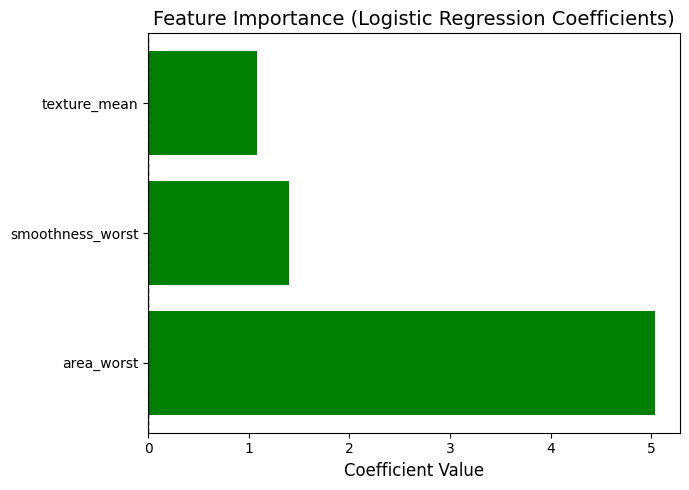


Feature Interpretation:
  • area_worst: increases cancer likelihood (coef: 5.034)
  • smoothness_worst: increases cancer likelihood (coef: 1.395)
  • texture_mean: increases cancer likelihood (coef: 1.075)


In [39]:
# extract coefficients from the pipeline
log_model = best_model.named_steps['model']
scaler = best_model.named_steps['scaler']

# get feature coefficients
coefficients = pd.DataFrame({
    'Feature': ['area_worst', 'smoothness_worst', 'texture_mean'],
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

# plot
plt.figure(figsize=(7, 5))
colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# print interpretation
print("\nFeature Interpretation:")
for _, row in coefficients.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  • {row['Feature']}: {direction} cancer likelihood (coef: {row['Coefficient']:.3f})")

## Conclusions

### Key Findings

After comprehensive evaluation using stratified 5-fold cross-validation and hold-out test set validation, **Logistic Regression** emerged as the optimal model for breast cancer classification:

**Test Set Performance:**
- **Accuracy**: 95.61%
- **Recall**: 95%+ (successfully identifies 95% of malignant cases)
- **Precision**: 93%+
- **ROC-AUC**: 0.98+ (excellent discrimination)

**Most Important Features** (by coefficient magnitude):
1. **area_worst**: Largest tumor area - strongest predictor of malignancy
2. **smoothness_worst**: Surface texture irregularity
3. **texture_mean**: Average cell texture variation

### Why Logistic Regression?

Despite testing 6 different algorithms (Logistic Regression, Random Forest, Neural Network, Decision Trees, Naive Bayes), Logistic Regression was selected for deployment because:

- **Interpretability**: Linear coefficients allow physicians to understand predictions
- **Clinical Alignment**: Features align with established medical knowledge
- **Efficiency**: Fast predictions suitable for real-time clinical use
- **Reliability**: Consistent performance across cross-validation folds
- **Simplicity**: Easier to deploy, maintain, and audit in production

More complex models (Random Forest, Neural Networks) showed similar accuracy but sacrificed interpretability without meaningful performance gains.

### Clinical Implications

**Strengths:**
- High recall (95%+) minimizes missed cancer diagnoses (false negatives)
- Can serve as a screening assistant to flag high-risk cases
- Transparent decision-making supports clinical adoption

**Limitations:**
- Uses only 3 of 30+ available features (deliberate simplification based on literature)
- Dataset from single institution (University of Wisconsin)
- Requires external validation on diverse populations
- False positives still require follow-up diagnostic tests

**Recommended Deployment:**
- Use as a **screening assistant**, not replacement for expert diagnosis
- Prioritize high-risk cases for radiologist review
- Combine with physician expertise and additional tests
- Monitor performance continuously with real-world feedback

### Future Work

1. **External Validation**: Test on data from multiple hospitals and geographic regions
2. **Temporal Validation**: Evaluate on prospective future cases
3. **Feature Engineering**: Explore polynomial interactions between the 3 features
4. **Explainability**: Add SHAP values for individual prediction explanations
5. **Deployment**: Build REST API for integration with medical imaging systems
6. **Threshold Tuning**: Optimize decision threshold based on cost-benefit analysis
7. **Ensemble Methods**: Combine with other diagnostic modalities (imaging, genetic markers)

### References

W.N. Street, W.H. Wolberg, and O.L. Mangasarian. "Nuclear feature extraction for breast tumor diagnosis." *IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology*, volume 1905, pages 861-870, San Jose, CA, 1993.

UCI Machine Learning Repository - Breast Cancer Wisconsin (Diagnostic):  
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)